To prepare our CIFAR10 dataset for training, we apply data augmentation techniques and transforms. Specifically, we use the following techniques:

Random Crop: This technique creates a random subset of an original image. We use this to randomly crop 32x32-pixel patches from the original images, which helps our model learn to recognize objects that might appear anywhere in the image.

Random Horizontal Flip: This technique flips an image horizontally with a probability p. We use this to further augment our dataset and make our model more robust to variations in the orientation of objects.

To Tensor: We use the To Tensor transform to convert our images to PyTorch tensors and scale the pixel values by 255.

Normalize: We apply the Normalize transform to the tensor images so that their values have a mean of 0.0 and a standard deviation of 1.0. This helps our model learn from the input data more effectively.

We download the CIFAR10 dataset to the root directory ./data. To ensure that we get the same validation set each time we run the code, we set PyTorch's random number generator to a seed value of 17. We also import the datasets and convert the images into PyTorch tensors.


In [ ]:
import multiprocessing
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(17)

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

class FetchDataset:

    def __init__(self, dataset="CIFAR10", batch_size=64):
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        # check if the dataset exists in torchvision
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s might not be in torchvision."%(dataset))
        self.batch_size = batch_size
        self.transformers_training = []
        self.transformers_testing = []
        # set number of workers available for multiprocessing
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)
      
    def dataAugmentation(self, size=32, padding=3):
        # add data augmentation transforms to the training set
        self.transformers_training.append(transforms.RandomHorizontalFlip())
        self.transformers_training.append(transforms.RandomCrop(size=size, padding=padding))
        self.transformers_training.append(transforms.functional.equalize)
        self.transformers_testing.append(transforms.functional.equalize)

    def __addToTensor(self):
        # add ToTensor transform to the training and testing sets
        self.transformers_training.append(transforms.ToTensor())
        self.transformers_testing.append(transforms.ToTensor())

    def addNormalizer(self):
        self.__addToTensor()
        # load training set to compute mean and standard deviation
        dataset_training = self.datasetObject(root="./data", train=True, download=True)
        data_train = dataset_training.data/255.0
        mean = data_train.mean(axis=(0, 1, 2))
        std = data_train.std(axis=(0, 1, 2))
        # add Normalize transform to the training and testing sets
        self.transformers_training.append(transforms.Normalize(mean=mean, std=std))
        self.transformers_testing.append(transforms.Normalize(mean=mean, std=std))
        

    def getLoaders(self):
        if len(self.transformers_training) == 0:
            self.__addToTensor()
        # create data loaders with the defined batch size, transformers and number of workers
        dataset_training = self.datasetObject(root="./data", train=True, download=True, transform=transforms.Compose(self.transformers_training))
        dataset_testing = self.datasetObject(root="./data", train=False, download=True, transform=transforms.Compose(self.transformers_testing))
        load_train = DataLoader(dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=self.workersAvailable)
        load_test = DataLoader(dataset_testing, batch_size=self.batch_size, shuffle=False, num_workers=self.workersAvailable)
        # return the training and testing data loaders
        return load_train, load_test
    
# create a new instance of FetchDataset for the CIFAR10 dataset with batch size of 128
df = FetchDataset(dataset="CIFAR10", batch_size=128)
# add data augmentation transforms to the training set with size 32 and padding 4
df.dataAugmentation(size=32, padding=4)
# add normalizing transforms to the training and testing sets
df.addNormalizer()
# get the training and testing data loaders
trainLoader, testLoader = df.getLoaders()


Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:02<00:00, 63156896.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Modified the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py 

• Ci, the number of channels in the ith layer.
• Fi, the filter size in the ith layer
• Ki, the kernel size in the ith skip connection
• P, the pool size in the average pool laye

Using the following values for the Hyperparameters (design variables) in our architectures : 

    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]  
    P=4



In [ ]:
# Import necessary PyTorch modules
import torch.nn as nn
import torch.nn.functional as F

# Define the BasicBlock class, which is used to construct the layers in the ResNet architecture
class BasicBlock(nn.Module):

    # Initialize the BasicBlock class
    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Define the shortcut connection, which is used to add the output of the convolutional layers to the input
        self.shortcut = nn.Sequential()

        # If the stride is not 1 or the number of input planes is not equal to the number of output planes, 
        # define a convolutional layer and a batch normalization layer for the shortcut connection
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    # Define the forward pass for the BasicBlock class
    def forward(self, x):
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))

        # Apply the second convolutional layer and batch normalization
        out = self.bn2(self.conv2(out))

        # Add the shortcut connection to the output of the convolutional layers
        out += self.shortcut(x)

        # Apply the ReLU activation
        out = F.relu(out)

        return out

# Define the ResNet class, which is used to construct the ResNet architecture
class ResNet(nn.Module):

      # Initialize the ResNet class
      def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
          super(ResNet, self).__init__()

          # Initialize the number of input planes
          self.in_planes = C[0]

          # Set the block to the BasicBlock class
          self.block = BasicBlock

          # Store the values of N, B, C, F, K, and P
          self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P

          # Initialize a container for the layers
          self.layers = []

          # Set the stride for each layer
          self.S = [2] * N
          self.S[0] = 1

          # Calculate the input dimension for the output linear layer
          self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))


          # Print Model Config
          print("\n\nModel Config: "
              "\n-------------------------------------"
              "\nN (# Layers)\t:",self.N,
              "\nB (# Blocks)\t:",self.B,
              "\nC (# Channels)\t:",C,
              "\nF (Conv Kernel)\t:",F,
              "\nK (Skip Kernel)\t:",K,
              "\nP (Pool Kernel)\t:",P,)

          # Define the first convolution layer with 3 input channels, C[0] output channels, F[0] kernel size,
          # stride of 1, padding of 1, and no bias

          self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
          # Define a batch normalization layer with C[0] channels

          self.bn1 = nn.BatchNorm2d(C[0])
                  # Define N residual blocks

          for i in range(N): 
              # Dynamically create variable names for each residual block using the exec() function

              exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                  .format(i+1,i,i,i,i,i))
              # Append the residual block to the layers ModuleList
              exec("self.layers.append(self.layer{})".format(i+1))
                    # Define the final linear layer with input size of outLayerInSize and output size of num_classes
    
          self.linear = nn.Linear(self.outLayerInSize, num_classes)
          

      def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
          # Set stride for each block in the layer
          strides = [stride] + [1]*(num_blocks-1)
          layers = []
          for stride in strides:
              # Append each block to the layer with given arguments
              layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
              # Update the number of input planes for the next block
              self.in_planes = planes
          # Return a sequential module containing all the blocks in the layer
          return nn.Sequential(*layers)


      def forward(self, x):
          # Apply the first convolutional layer followed by batch normalization and ReLU activation
          out = F.relu(self.bn1(self.conv1(x)))
          # Apply all the blocks in the layer
          for layer in self.layers:
              out = layer(out)
          # Apply average pooling with kernel size self.P
          out = F.avg_pool2d(out, self.P)
          # Flatten the output tensor
          out = out.view(out.size(0), -1)
          # Apply the fully connected linear layer
          out = self.linear(out)
          # Return the final output
          return out

def resnet_model():
        # Define the parameters for the ResNet architecture
        B=[3,3,2,3]  # number of blocks in each layer
        C=[64,128,128,256]  # number of output channels in each layer
        F=[3,3,3,3]  # kernel size for each layer
        K=[1,1,1,1]  # skip kernel size for each layer
        P=4  # average pooling kernel size
        N=len(B)  # number of layers in the network
        # Return a new ResNet model with the defined parameters
        return ResNet(N, B, C, F, K, P)


Checking Device - If GPU is available, GPU will be used.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = resnet_model()
model = model.to(device)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


We run our model for 300 epochs, to find out the best possible accuracy. The accuracy becomes near about constant after it. We define our:

learning rate, weightDecay, type of optimizer to be used (we tried with Adam, Adagrad, AdaDelta), with Adadelta giving out the best accuracy.

The scheduler set the learning rate of each parameter group using a cosine annealing schedule


In [ ]:
EPOCHS=300
globalBestAccuracy = 0.0  # initialize the global best accuracy to 0.0
train_loss = []  # list to store train loss
test_loss = []  # list to store test loss
train_accuracy = []  # list to store train accuracy
test_accuracy = []  # list to store test accuracy

# define the loss function as Cross Entropy Loss with sum reduction
loss_function = torch.nn.CrossEntropyLoss(reduction='sum')

learningRate = 0.001  # set the learning rate to 0.001
weightDecay = 0.0001  # set the weight decay to 0.0001

# define the optimizer as Adadelta with the above defined learning rate and weight decay
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)

# define the learning rate scheduler as Cosine Annealing LR with the above defined optimizer, number of epochs, and minimum learning rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)

# print the model's evaluation mode
print(model.eval())

# calculate and print the total trainable parameters of the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))

# if the total number of trainable parameters exceeds 5 million, raise an exception
if trainable_parameters > 5*(10**6):
    raise Exception("The total number of parameters exceeds 5 million")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Model Training and Testing.
Here we are training our model over 300 epochs and trying to find out the best accuracy our model provides for the CIFAR dataset.

In [ ]:
# Define the function to train the model and return the updated model and optimizer
def train(model, loader, optimizer):
    # Set the model to train mode
    model.train()
    # Clear the gradients of the optimizer
    optimizer.zero_grad()
    # Return the updated model and optimizer
    return model, optimizer

# Define the function to evaluate the model on the test set
def test(model, loader):
    # Set the model to evaluation mode
    return model.eval()

# Define the function to calculate the loss and accuracy for a given loader and model
def getLoss(loader, model, optimizer, phase):
    # Initialize the running loss and correct count
    running_loss = 0.0
    running_correct = 0
    # Iterate through the loader
    for images, labels in loader:
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        output = model(images)
        # Calculate the loss
        loss = loss_function(output, labels)
        # Calculate the predicted labels
        predicted_labels = torch.argmax(output, dim=1)
        # Update the running loss and correct count
        running_loss += loss.item()
        running_correct += torch.sum(predicted_labels == labels).float().item()
        # If the phase is "train", backpropagate the loss and update the optimizer
        if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    # Calculate the epoch loss and accuracy
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_correct / len(loader.dataset)
    # Return the epoch loss and accuracy
    return epoch_loss, epoch_acc

# Iterate through the epochs
for i in tqdm(range(EPOCHS)):
    # Iterate through the phases (train and test)
    for phase in ['train', 'test']:
        # If the phase is "train", set the loader and call the train function
        if phase == "train":
            loader = trainLoader
            model, optimizer = train(model, loader, optimizer)
        # If the phase is "test", set the loader and call the test function
        else:
            loader = testLoader
            model = test(model, loader)
        # Calculate the loss and accuracy for the current phase
        epoch_loss, epoch_acc = getLoss(loader, model, optimizer, phase)
        # If the phase is "train", update the scheduler and append the results to the train lists
        if phase == "train":
            scheduler.step()
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        # If the phase is "test", append the results to the test lists and update the global best accuracy
        else:
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            globalBestAccuracy = max(globalBestAccuracy, epoch_acc)
    # Print the results for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s" \
          % (train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1]))


  0%|          | 1/300 [00:59<4:55:23, 59.28s/it]

Training Loss : 2.3302755294799806, Testing Loss : 2.2376379322052, Training Accuracy : 0.12612, Testing Accuracy : 0.1733


  1%|          | 2/300 [01:51<4:33:18, 55.03s/it]

Training Loss : 2.1800979666137694, Testing Loss : 2.105339261627197, Training Accuracy : 0.19764, Testing Accuracy : 0.2379


  1%|          | 3/300 [02:42<4:24:21, 53.41s/it]

Training Loss : 2.066545298461914, Testing Loss : 1.989836116218567, Training Accuracy : 0.2472, Testing Accuracy : 0.2829


  1%|▏         | 4/300 [03:34<4:19:31, 52.61s/it]

Training Loss : 1.9536855908203126, Testing Loss : 1.8889239568710328, Training Accuracy : 0.29152, Testing Accuracy : 0.3224


  2%|▏         | 5/300 [04:26<4:17:34, 52.39s/it]

Training Loss : 1.86410318359375, Testing Loss : 1.8164858673095703, Training Accuracy : 0.32394, Testing Accuracy : 0.3534


  2%|▏         | 6/300 [05:18<4:17:12, 52.49s/it]

Training Loss : 1.8066582479858397, Testing Loss : 1.77198698387146, Training Accuracy : 0.35034, Testing Accuracy : 0.3673


  2%|▏         | 7/300 [06:11<4:16:12, 52.47s/it]

Training Loss : 1.7557713940429687, Testing Loss : 1.726117094039917, Training Accuracy : 0.3681, Testing Accuracy : 0.381


  3%|▎         | 8/300 [07:03<4:15:00, 52.40s/it]

Training Loss : 1.706555347290039, Testing Loss : 1.6913350030899048, Training Accuracy : 0.38646, Testing Accuracy : 0.4002


  3%|▎         | 9/300 [07:56<4:15:07, 52.60s/it]

Training Loss : 1.6625385479736328, Testing Loss : 1.6443766328811646, Training Accuracy : 0.40182, Testing Accuracy : 0.4164


  3%|▎         | 10/300 [08:48<4:13:10, 52.38s/it]

Training Loss : 1.6269939767456054, Testing Loss : 1.6197947128295898, Training Accuracy : 0.41784, Testing Accuracy : 0.4217


  4%|▎         | 11/300 [09:41<4:12:57, 52.52s/it]

Training Loss : 1.5883992578125, Testing Loss : 1.584962646484375, Training Accuracy : 0.43122, Testing Accuracy : 0.4377


  4%|▍         | 12/300 [10:33<4:12:09, 52.53s/it]

Training Loss : 1.556598942565918, Testing Loss : 1.5567666582107544, Training Accuracy : 0.44386, Testing Accuracy : 0.4452


  4%|▍         | 13/300 [11:26<4:11:18, 52.54s/it]

Training Loss : 1.5279970127868652, Testing Loss : 1.5441452472686767, Training Accuracy : 0.45124, Testing Accuracy : 0.452


  5%|▍         | 14/300 [12:19<4:10:33, 52.57s/it]

Training Loss : 1.5019983236694336, Testing Loss : 1.521228881263733, Training Accuracy : 0.4633, Testing Accuracy : 0.4556


  5%|▌         | 15/300 [13:11<4:09:54, 52.61s/it]

Training Loss : 1.4764140660095215, Testing Loss : 1.4955274351119996, Training Accuracy : 0.47412, Testing Accuracy : 0.4708


  5%|▌         | 16/300 [14:04<4:09:16, 52.66s/it]

Training Loss : 1.4539192327880859, Testing Loss : 1.4563615045547484, Training Accuracy : 0.48494, Testing Accuracy : 0.4795


  6%|▌         | 17/300 [14:57<4:08:32, 52.70s/it]

Training Loss : 1.4299799559020996, Testing Loss : 1.4509963914871216, Training Accuracy : 0.49002, Testing Accuracy : 0.4855


  6%|▌         | 18/300 [15:51<4:09:34, 53.10s/it]

Training Loss : 1.4122258882141114, Testing Loss : 1.4250725547790528, Training Accuracy : 0.49776, Testing Accuracy : 0.4932


  6%|▋         | 19/300 [16:44<4:09:20, 53.24s/it]

Training Loss : 1.3954387979125977, Testing Loss : 1.4033933549880981, Training Accuracy : 0.50176, Testing Accuracy : 0.501


  7%|▋         | 20/300 [17:37<4:07:21, 53.01s/it]

Training Loss : 1.368726671295166, Testing Loss : 1.3907081443786622, Training Accuracy : 0.51354, Testing Accuracy : 0.5053


  7%|▋         | 21/300 [18:30<4:06:56, 53.11s/it]

Training Loss : 1.3497931159973144, Testing Loss : 1.38423984375, Training Accuracy : 0.51872, Testing Accuracy : 0.5087


  7%|▋         | 22/300 [19:23<4:05:58, 53.09s/it]

Training Loss : 1.3379231217956542, Testing Loss : 1.3628114265441895, Training Accuracy : 0.52218, Testing Accuracy : 0.5145


  8%|▊         | 23/300 [20:17<4:05:24, 53.16s/it]

Training Loss : 1.3202289453125, Testing Loss : 1.3608606285095215, Training Accuracy : 0.52996, Testing Accuracy : 0.5161


  8%|▊         | 24/300 [21:10<4:04:29, 53.15s/it]

Training Loss : 1.3033856117248535, Testing Loss : 1.330485121536255, Training Accuracy : 0.53584, Testing Accuracy : 0.5232


  8%|▊         | 25/300 [22:02<4:02:36, 52.93s/it]

Training Loss : 1.2896064360046386, Testing Loss : 1.3089887073516846, Training Accuracy : 0.54108, Testing Accuracy : 0.5325


  9%|▊         | 26/300 [22:55<4:01:16, 52.83s/it]

Training Loss : 1.275663239135742, Testing Loss : 1.2978259906768799, Training Accuracy : 0.54786, Testing Accuracy : 0.536


  9%|▉         | 27/300 [23:47<3:59:37, 52.67s/it]

Training Loss : 1.2588947496032714, Testing Loss : 1.279926103591919, Training Accuracy : 0.55238, Testing Accuracy : 0.5447


  9%|▉         | 28/300 [24:40<3:58:37, 52.64s/it]

Training Loss : 1.2495627093505859, Testing Loss : 1.267288840675354, Training Accuracy : 0.55598, Testing Accuracy : 0.5504


 10%|▉         | 29/300 [25:32<3:57:23, 52.56s/it]

Training Loss : 1.2333933677673339, Testing Loss : 1.2596893228530883, Training Accuracy : 0.56226, Testing Accuracy : 0.5526


 10%|█         | 30/300 [26:24<3:55:23, 52.31s/it]

Training Loss : 1.2199437823486328, Testing Loss : 1.240540146446228, Training Accuracy : 0.5672, Testing Accuracy : 0.5594


 10%|█         | 31/300 [27:16<3:54:23, 52.28s/it]

Training Loss : 1.2083785791015624, Testing Loss : 1.2281181840896607, Training Accuracy : 0.572, Testing Accuracy : 0.5644


 11%|█         | 32/300 [28:08<3:53:02, 52.17s/it]

Training Loss : 1.1984157386779786, Testing Loss : 1.2348511032104492, Training Accuracy : 0.57586, Testing Accuracy : 0.5607


 11%|█         | 33/300 [28:59<3:51:25, 52.01s/it]

Training Loss : 1.1820818676757812, Testing Loss : 1.2175111099243163, Training Accuracy : 0.5801, Testing Accuracy : 0.5683


 11%|█▏        | 34/300 [29:52<3:51:03, 52.12s/it]

Training Loss : 1.1752272467041016, Testing Loss : 1.2043127811431884, Training Accuracy : 0.5836, Testing Accuracy : 0.5749


 12%|█▏        | 35/300 [30:44<3:50:20, 52.15s/it]

Training Loss : 1.1637281964111328, Testing Loss : 1.2055995367050172, Training Accuracy : 0.58816, Testing Accuracy : 0.5751


 12%|█▏        | 36/300 [31:37<3:50:29, 52.38s/it]

Training Loss : 1.1480155680847168, Testing Loss : 1.185491773033142, Training Accuracy : 0.59212, Testing Accuracy : 0.5817


 12%|█▏        | 37/300 [32:29<3:48:34, 52.14s/it]

Training Loss : 1.1392427157592773, Testing Loss : 1.1724191440582274, Training Accuracy : 0.595, Testing Accuracy : 0.5863


 13%|█▎        | 38/300 [33:21<3:48:04, 52.23s/it]

Training Loss : 1.1296360804748535, Testing Loss : 1.1624054832458497, Training Accuracy : 0.60214, Testing Accuracy : 0.5896


 13%|█▎        | 39/300 [34:13<3:46:57, 52.17s/it]

Training Loss : 1.116548763885498, Testing Loss : 1.1543814849853515, Training Accuracy : 0.60368, Testing Accuracy : 0.5931


 13%|█▎        | 40/300 [35:05<3:45:55, 52.14s/it]

Training Loss : 1.1128476052856446, Testing Loss : 1.1670999095916748, Training Accuracy : 0.60558, Testing Accuracy : 0.5871


 14%|█▎        | 41/300 [35:58<3:45:24, 52.22s/it]

Training Loss : 1.0991864750671387, Testing Loss : 1.142699208164215, Training Accuracy : 0.61024, Testing Accuracy : 0.5961


 14%|█▍        | 42/300 [36:49<3:44:12, 52.14s/it]

Training Loss : 1.0898991386413575, Testing Loss : 1.1324939359664916, Training Accuracy : 0.61758, Testing Accuracy : 0.5998


 14%|█▍        | 43/300 [37:42<3:43:44, 52.24s/it]

Training Loss : 1.0846185192871094, Testing Loss : 1.1234448356628417, Training Accuracy : 0.61768, Testing Accuracy : 0.6015


 15%|█▍        | 44/300 [38:33<3:41:38, 51.95s/it]

Training Loss : 1.0743179658508302, Testing Loss : 1.117394988632202, Training Accuracy : 0.62124, Testing Accuracy : 0.6058


 15%|█▌        | 45/300 [39:25<3:40:43, 51.93s/it]

Training Loss : 1.0658008206176757, Testing Loss : 1.1023930515289306, Training Accuracy : 0.6255, Testing Accuracy : 0.6127


 15%|█▌        | 46/300 [40:17<3:39:45, 51.91s/it]

Training Loss : 1.0530667778015137, Testing Loss : 1.0926283399581909, Training Accuracy : 0.62642, Testing Accuracy : 0.6177


 16%|█▌        | 47/300 [41:09<3:39:09, 51.97s/it]

Training Loss : 1.0514477851867676, Testing Loss : 1.0894517850875856, Training Accuracy : 0.62958, Testing Accuracy : 0.6174


 16%|█▌        | 48/300 [42:01<3:38:06, 51.93s/it]

Training Loss : 1.0438542851257324, Testing Loss : 1.079536503791809, Training Accuracy : 0.62924, Testing Accuracy : 0.6193


 16%|█▋        | 49/300 [42:54<3:38:21, 52.20s/it]

Training Loss : 1.0343946444702148, Testing Loss : 1.084318590927124, Training Accuracy : 0.63466, Testing Accuracy : 0.6163


 17%|█▋        | 50/300 [43:45<3:36:23, 51.93s/it]

Training Loss : 1.0215884552001953, Testing Loss : 1.077563952255249, Training Accuracy : 0.6391, Testing Accuracy : 0.6195


 17%|█▋        | 51/300 [44:37<3:35:21, 51.89s/it]

Training Loss : 1.016352422027588, Testing Loss : 1.061165160179138, Training Accuracy : 0.64042, Testing Accuracy : 0.626


 17%|█▋        | 52/300 [45:29<3:34:18, 51.85s/it]

Training Loss : 1.0107727639770507, Testing Loss : 1.0573348220825196, Training Accuracy : 0.64372, Testing Accuracy : 0.6297


 18%|█▊        | 53/300 [46:21<3:33:30, 51.87s/it]

Training Loss : 1.0019399932861328, Testing Loss : 1.0609624131202697, Training Accuracy : 0.64758, Testing Accuracy : 0.629


 18%|█▊        | 54/300 [47:12<3:32:45, 51.89s/it]

Training Loss : 0.9962878680419922, Testing Loss : 1.0407556003570557, Training Accuracy : 0.64934, Testing Accuracy : 0.6355


 18%|█▊        | 55/300 [48:04<3:31:01, 51.68s/it]

Training Loss : 0.9867826179504394, Testing Loss : 1.0484647336006165, Training Accuracy : 0.65264, Testing Accuracy : 0.6334


 19%|█▊        | 56/300 [48:56<3:30:28, 51.76s/it]

Training Loss : 0.9831711340332031, Testing Loss : 1.0343383977890015, Training Accuracy : 0.65362, Testing Accuracy : 0.6389


 19%|█▉        | 57/300 [49:47<3:29:36, 51.76s/it]

Training Loss : 0.9753326629638672, Testing Loss : 1.0249795289993286, Training Accuracy : 0.65846, Testing Accuracy : 0.6421


 19%|█▉        | 58/300 [50:39<3:28:39, 51.73s/it]

Training Loss : 0.9638893608093262, Testing Loss : 1.0281381101608276, Training Accuracy : 0.65924, Testing Accuracy : 0.6418


 20%|█▉        | 59/300 [51:31<3:27:43, 51.72s/it]

Training Loss : 0.9591435650634765, Testing Loss : 1.019882053756714, Training Accuracy : 0.66052, Testing Accuracy : 0.6471


 20%|██        | 60/300 [52:22<3:25:47, 51.45s/it]

Training Loss : 0.9531505204772949, Testing Loss : 1.0101266613006592, Training Accuracy : 0.66388, Testing Accuracy : 0.6499


 20%|██        | 61/300 [53:13<3:25:18, 51.54s/it]

Training Loss : 0.949258900604248, Testing Loss : 1.0045483199119567, Training Accuracy : 0.66744, Testing Accuracy : 0.6532


 21%|██        | 62/300 [54:05<3:24:34, 51.57s/it]

Training Loss : 0.9385984059143067, Testing Loss : 0.9949243926048279, Training Accuracy : 0.66944, Testing Accuracy : 0.6534


 21%|██        | 63/300 [54:57<3:23:46, 51.59s/it]

Training Loss : 0.9340343475341797, Testing Loss : 0.9952969148635864, Training Accuracy : 0.67308, Testing Accuracy : 0.6588


 21%|██▏       | 64/300 [55:48<3:23:11, 51.66s/it]

Training Loss : 0.9249619648742676, Testing Loss : 0.9897576169967651, Training Accuracy : 0.67458, Testing Accuracy : 0.6566


 22%|██▏       | 65/300 [56:39<3:21:34, 51.47s/it]

Training Loss : 0.9192296015930176, Testing Loss : 0.9886157735824584, Training Accuracy : 0.67856, Testing Accuracy : 0.6596


 22%|██▏       | 66/300 [57:31<3:20:40, 51.46s/it]

Training Loss : 0.9206287948608398, Testing Loss : 0.9829085377693176, Training Accuracy : 0.67488, Testing Accuracy : 0.6617


 22%|██▏       | 67/300 [58:22<3:19:48, 51.45s/it]

Training Loss : 0.9131725761413574, Testing Loss : 0.9765499263763427, Training Accuracy : 0.67986, Testing Accuracy : 0.6664


 23%|██▎       | 68/300 [59:13<3:18:37, 51.37s/it]

Training Loss : 0.9036998314666748, Testing Loss : 0.9671326758384705, Training Accuracy : 0.68316, Testing Accuracy : 0.6682


 23%|██▎       | 69/300 [1:00:05<3:17:31, 51.30s/it]

Training Loss : 0.900858835144043, Testing Loss : 0.9631631039619446, Training Accuracy : 0.68312, Testing Accuracy : 0.6687


 23%|██▎       | 70/300 [1:00:56<3:16:56, 51.38s/it]

Training Loss : 0.8931233306884766, Testing Loss : 0.9578061486244202, Training Accuracy : 0.68676, Testing Accuracy : 0.6738


 24%|██▎       | 71/300 [1:01:48<3:16:13, 51.41s/it]

Training Loss : 0.8919682344055175, Testing Loss : 0.9526526383399964, Training Accuracy : 0.68716, Testing Accuracy : 0.6744


 24%|██▍       | 72/300 [1:02:40<3:15:57, 51.57s/it]

Training Loss : 0.8815233830261231, Testing Loss : 0.9503821634292603, Training Accuracy : 0.68894, Testing Accuracy : 0.6725


 24%|██▍       | 73/300 [1:03:32<3:15:30, 51.68s/it]

Training Loss : 0.8804036399841308, Testing Loss : 0.9479284317970276, Training Accuracy : 0.69184, Testing Accuracy : 0.6757


 25%|██▍       | 74/300 [1:04:23<3:14:19, 51.59s/it]

Training Loss : 0.8766143972778321, Testing Loss : 0.9533550196647644, Training Accuracy : 0.69058, Testing Accuracy : 0.672


 25%|██▌       | 75/300 [1:05:15<3:14:05, 51.76s/it]

Training Loss : 0.8685102596282959, Testing Loss : 0.9382090277671814, Training Accuracy : 0.69316, Testing Accuracy : 0.6775


 25%|██▌       | 76/300 [1:06:07<3:13:36, 51.86s/it]

Training Loss : 0.8608340579223632, Testing Loss : 0.9369188543319702, Training Accuracy : 0.69888, Testing Accuracy : 0.6802


 26%|██▌       | 77/300 [1:06:59<3:12:53, 51.90s/it]

Training Loss : 0.8567653742980957, Testing Loss : 0.930767796421051, Training Accuracy : 0.6985, Testing Accuracy : 0.6789


 26%|██▌       | 78/300 [1:07:50<3:11:21, 51.72s/it]

Training Loss : 0.8491772866821289, Testing Loss : 0.918894373703003, Training Accuracy : 0.7002, Testing Accuracy : 0.6814


 26%|██▋       | 79/300 [1:08:42<3:10:37, 51.75s/it]

Training Loss : 0.8456308872985839, Testing Loss : 0.9260886274337768, Training Accuracy : 0.7032, Testing Accuracy : 0.6796


 27%|██▋       | 80/300 [1:09:34<3:09:43, 51.74s/it]

Training Loss : 0.8427738986206055, Testing Loss : 0.9132624418258667, Training Accuracy : 0.70408, Testing Accuracy : 0.6865


 27%|██▋       | 81/300 [1:10:26<3:09:31, 51.92s/it]

Training Loss : 0.8389222798156738, Testing Loss : 0.9143453728675842, Training Accuracy : 0.70702, Testing Accuracy : 0.6834


 27%|██▋       | 82/300 [1:11:19<3:09:45, 52.23s/it]

Training Loss : 0.8317069567108154, Testing Loss : 0.9202948621749878, Training Accuracy : 0.70822, Testing Accuracy : 0.6851


 28%|██▊       | 83/300 [1:12:11<3:08:07, 52.02s/it]

Training Loss : 0.826403046875, Testing Loss : 0.9085869963645935, Training Accuracy : 0.71136, Testing Accuracy : 0.6861


 28%|██▊       | 84/300 [1:13:03<3:06:58, 51.94s/it]

Training Loss : 0.8242202591705322, Testing Loss : 0.8978699456214905, Training Accuracy : 0.71022, Testing Accuracy : 0.6882


 28%|██▊       | 85/300 [1:13:54<3:05:07, 51.66s/it]

Training Loss : 0.8208591860961914, Testing Loss : 0.9094253799438476, Training Accuracy : 0.7129, Testing Accuracy : 0.6864


 29%|██▊       | 86/300 [1:14:45<3:04:08, 51.63s/it]

Training Loss : 0.8162606964111329, Testing Loss : 0.8919789839744567, Training Accuracy : 0.71632, Testing Accuracy : 0.6921


 29%|██▉       | 87/300 [1:15:36<3:02:12, 51.32s/it]

Training Loss : 0.8109617622375488, Testing Loss : 0.888532534122467, Training Accuracy : 0.71614, Testing Accuracy : 0.6968


 29%|██▉       | 88/300 [1:16:27<3:00:58, 51.22s/it]

Training Loss : 0.8057002756500244, Testing Loss : 0.8866221133232117, Training Accuracy : 0.71804, Testing Accuracy : 0.6955


 30%|██▉       | 89/300 [1:17:18<2:59:45, 51.11s/it]

Training Loss : 0.8042900648498535, Testing Loss : 0.8899623345375061, Training Accuracy : 0.72, Testing Accuracy : 0.6959


 30%|███       | 90/300 [1:18:09<2:59:28, 51.28s/it]

Training Loss : 0.7971516540527344, Testing Loss : 0.887058837890625, Training Accuracy : 0.722, Testing Accuracy : 0.6962


 30%|███       | 91/300 [1:19:00<2:57:45, 51.03s/it]

Training Loss : 0.7928802001953125, Testing Loss : 0.8775093267440796, Training Accuracy : 0.72154, Testing Accuracy : 0.7004


 31%|███       | 92/300 [1:19:51<2:56:41, 50.97s/it]

Training Loss : 0.7881345213317871, Testing Loss : 0.876437825679779, Training Accuracy : 0.72498, Testing Accuracy : 0.6974


 31%|███       | 93/300 [1:20:42<2:56:26, 51.14s/it]

Training Loss : 0.7874258981323242, Testing Loss : 0.8726165979385376, Training Accuracy : 0.72582, Testing Accuracy : 0.7036


 31%|███▏      | 94/300 [1:21:34<2:56:20, 51.36s/it]

Training Loss : 0.7828336709594726, Testing Loss : 0.8716294746398926, Training Accuracy : 0.72638, Testing Accuracy : 0.7029


 32%|███▏      | 95/300 [1:22:24<2:54:26, 51.06s/it]

Training Loss : 0.7794900206756592, Testing Loss : 0.8682725026130677, Training Accuracy : 0.72758, Testing Accuracy : 0.7035


 32%|███▏      | 96/300 [1:23:15<2:53:16, 50.96s/it]

Training Loss : 0.7802376372528076, Testing Loss : 0.8630575058937072, Training Accuracy : 0.72992, Testing Accuracy : 0.7059


 32%|███▏      | 97/300 [1:24:06<2:52:38, 51.02s/it]

Training Loss : 0.7696206253814697, Testing Loss : 0.8601488072395325, Training Accuracy : 0.73112, Testing Accuracy : 0.7068


 33%|███▎      | 98/300 [1:24:57<2:51:24, 50.91s/it]

Training Loss : 0.7689883731079101, Testing Loss : 0.8646409945487976, Training Accuracy : 0.7297, Testing Accuracy : 0.7025


 33%|███▎      | 99/300 [1:25:48<2:50:34, 50.92s/it]

Training Loss : 0.7620670502471923, Testing Loss : 0.8584285460472106, Training Accuracy : 0.73268, Testing Accuracy : 0.7056


 33%|███▎      | 100/300 [1:26:39<2:49:46, 50.93s/it]

Training Loss : 0.7586766351318359, Testing Loss : 0.859719076538086, Training Accuracy : 0.73476, Testing Accuracy : 0.7054


 34%|███▎      | 101/300 [1:27:30<2:49:11, 51.01s/it]

Training Loss : 0.754823023223877, Testing Loss : 0.8509044174194336, Training Accuracy : 0.73548, Testing Accuracy : 0.7119


 34%|███▍      | 102/300 [1:28:21<2:48:07, 50.95s/it]

Training Loss : 0.7524405961608887, Testing Loss : 0.8511079051971435, Training Accuracy : 0.73536, Testing Accuracy : 0.7071


 34%|███▍      | 103/300 [1:29:12<2:47:40, 51.07s/it]

Training Loss : 0.7487065507507324, Testing Loss : 0.8469164655685425, Training Accuracy : 0.7375, Testing Accuracy : 0.7118


 35%|███▍      | 104/300 [1:30:03<2:46:47, 51.06s/it]

Training Loss : 0.7466765863800049, Testing Loss : 0.8460192555427551, Training Accuracy : 0.74098, Testing Accuracy : 0.712


 35%|███▌      | 105/300 [1:30:56<2:47:31, 51.55s/it]

Training Loss : 0.7417825612640381, Testing Loss : 0.8431708649635314, Training Accuracy : 0.73966, Testing Accuracy : 0.7129


 35%|███▌      | 106/300 [1:31:47<2:46:32, 51.51s/it]

Training Loss : 0.7356565464782715, Testing Loss : 0.8400452352523804, Training Accuracy : 0.7437, Testing Accuracy : 0.7115


 36%|███▌      | 107/300 [1:32:39<2:45:52, 51.57s/it]

Training Loss : 0.7354266311645508, Testing Loss : 0.8397464994430542, Training Accuracy : 0.74296, Testing Accuracy : 0.712


 36%|███▌      | 108/300 [1:33:32<2:45:59, 51.87s/it]

Training Loss : 0.732104012298584, Testing Loss : 0.837688184261322, Training Accuracy : 0.74484, Testing Accuracy : 0.7151


 36%|███▋      | 109/300 [1:34:24<2:45:29, 51.98s/it]

Training Loss : 0.7312503077697754, Testing Loss : 0.8357272541046142, Training Accuracy : 0.74444, Testing Accuracy : 0.7144


 37%|███▋      | 110/300 [1:35:15<2:43:38, 51.68s/it]

Training Loss : 0.7272765816497803, Testing Loss : 0.8426239525794983, Training Accuracy : 0.7467, Testing Accuracy : 0.7104


 37%|███▋      | 111/300 [1:36:06<2:42:51, 51.70s/it]

Training Loss : 0.7225382384490967, Testing Loss : 0.8277552762031555, Training Accuracy : 0.74742, Testing Accuracy : 0.7175


 37%|███▋      | 112/300 [1:36:58<2:41:59, 51.70s/it]

Training Loss : 0.7232051644134522, Testing Loss : 0.8285332593441009, Training Accuracy : 0.74698, Testing Accuracy : 0.7172


 38%|███▊      | 113/300 [1:37:49<2:40:18, 51.44s/it]

Training Loss : 0.717964534072876, Testing Loss : 0.8240204976081849, Training Accuracy : 0.749, Testing Accuracy : 0.7177


 38%|███▊      | 114/300 [1:38:41<2:39:42, 51.52s/it]

Training Loss : 0.71279696434021, Testing Loss : 0.8287187553405762, Training Accuracy : 0.7518, Testing Accuracy : 0.7164


 38%|███▊      | 115/300 [1:39:32<2:38:58, 51.56s/it]

Training Loss : 0.7133254125976562, Testing Loss : 0.822620842885971, Training Accuracy : 0.75208, Testing Accuracy : 0.7183


 39%|███▊      | 116/300 [1:40:24<2:38:33, 51.70s/it]

Training Loss : 0.7062709171295166, Testing Loss : 0.8228168731212616, Training Accuracy : 0.75376, Testing Accuracy : 0.7169


 39%|███▉      | 117/300 [1:41:16<2:37:23, 51.60s/it]

Training Loss : 0.7081866450500488, Testing Loss : 0.8257977927207947, Training Accuracy : 0.75344, Testing Accuracy : 0.719


 39%|███▉      | 118/300 [1:42:07<2:36:19, 51.54s/it]

Training Loss : 0.7019697862243652, Testing Loss : 0.8152582844734192, Training Accuracy : 0.7574, Testing Accuracy : 0.7213


 40%|███▉      | 119/300 [1:42:59<2:35:43, 51.62s/it]

Training Loss : 0.7011977547454834, Testing Loss : 0.8110094345092773, Training Accuracy : 0.75346, Testing Accuracy : 0.7241


 40%|████      | 120/300 [1:43:51<2:35:28, 51.82s/it]

Training Loss : 0.6973335580444336, Testing Loss : 0.807154498577118, Training Accuracy : 0.7571, Testing Accuracy : 0.7248


 40%|████      | 121/300 [1:44:42<2:33:56, 51.60s/it]

Training Loss : 0.6967884708404541, Testing Loss : 0.809644556427002, Training Accuracy : 0.75616, Testing Accuracy : 0.7243


 41%|████      | 122/300 [1:45:34<2:33:18, 51.68s/it]

Training Loss : 0.6925562807464599, Testing Loss : 0.8097870592594146, Training Accuracy : 0.7605, Testing Accuracy : 0.7216


 41%|████      | 123/300 [1:46:26<2:32:09, 51.58s/it]

Training Loss : 0.6876038710784912, Testing Loss : 0.8095151605606079, Training Accuracy : 0.75812, Testing Accuracy : 0.7251


 41%|████▏     | 124/300 [1:47:17<2:30:48, 51.41s/it]

Training Loss : 0.6837809352111817, Testing Loss : 0.8132763421058655, Training Accuracy : 0.7622, Testing Accuracy : 0.7248


 42%|████▏     | 125/300 [1:48:08<2:30:15, 51.52s/it]

Training Loss : 0.684292452468872, Testing Loss : 0.8083933998584747, Training Accuracy : 0.76124, Testing Accuracy : 0.723


 42%|████▏     | 126/300 [1:49:00<2:29:28, 51.54s/it]

Training Loss : 0.6812598225402832, Testing Loss : 0.8028189610004425, Training Accuracy : 0.76242, Testing Accuracy : 0.7252


 42%|████▏     | 127/300 [1:49:52<2:28:50, 51.62s/it]

Training Loss : 0.6777583180999756, Testing Loss : 0.8037578841209412, Training Accuracy : 0.76428, Testing Accuracy : 0.7263


 43%|████▎     | 128/300 [1:50:43<2:27:26, 51.43s/it]

Training Loss : 0.6794801540374756, Testing Loss : 0.8052429594993591, Training Accuracy : 0.76386, Testing Accuracy : 0.7251


 43%|████▎     | 129/300 [1:51:34<2:26:44, 51.49s/it]

Training Loss : 0.6774738301086426, Testing Loss : 0.7986997215747833, Training Accuracy : 0.76186, Testing Accuracy : 0.7273


 43%|████▎     | 130/300 [1:52:26<2:26:15, 51.62s/it]

Training Loss : 0.6700889385223389, Testing Loss : 0.7969005400657654, Training Accuracy : 0.76542, Testing Accuracy : 0.731


 44%|████▎     | 131/300 [1:53:19<2:25:59, 51.83s/it]

Training Loss : 0.6721801474761963, Testing Loss : 0.7972584075450897, Training Accuracy : 0.76374, Testing Accuracy : 0.7303


 44%|████▍     | 132/300 [1:54:10<2:24:31, 51.62s/it]

Training Loss : 0.6633339641571044, Testing Loss : 0.7980364191055298, Training Accuracy : 0.76964, Testing Accuracy : 0.7245


 44%|████▍     | 133/300 [1:55:02<2:23:51, 51.68s/it]

Training Loss : 0.6665700027465821, Testing Loss : 0.792530521440506, Training Accuracy : 0.76782, Testing Accuracy : 0.7325


 45%|████▍     | 134/300 [1:55:53<2:23:00, 51.69s/it]

Training Loss : 0.6671720369720459, Testing Loss : 0.794489186000824, Training Accuracy : 0.76726, Testing Accuracy : 0.727


 45%|████▌     | 135/300 [1:56:44<2:21:29, 51.45s/it]

Training Loss : 0.6606291150665283, Testing Loss : 0.7921144254207612, Training Accuracy : 0.7703, Testing Accuracy : 0.7265


 45%|████▌     | 136/300 [1:57:36<2:20:49, 51.52s/it]

Training Loss : 0.6587756245422364, Testing Loss : 0.789256167602539, Training Accuracy : 0.77244, Testing Accuracy : 0.7278


 46%|████▌     | 137/300 [1:58:27<2:19:43, 51.43s/it]

Training Loss : 0.6577178137969971, Testing Loss : 0.7849105538368225, Training Accuracy : 0.77106, Testing Accuracy : 0.7304


 46%|████▌     | 138/300 [1:59:19<2:19:20, 51.61s/it]

Training Loss : 0.6559770851135254, Testing Loss : 0.7879712157726287, Training Accuracy : 0.7723, Testing Accuracy : 0.7282


 46%|████▋     | 139/300 [2:00:10<2:17:56, 51.41s/it]

Training Loss : 0.6548545720672607, Testing Loss : 0.7841992888927459, Training Accuracy : 0.77082, Testing Accuracy : 0.731


 47%|████▋     | 140/300 [2:01:01<2:17:08, 51.43s/it]

Training Loss : 0.6492717205810546, Testing Loss : 0.7813444545269013, Training Accuracy : 0.77418, Testing Accuracy : 0.731


 47%|████▋     | 141/300 [2:01:53<2:16:06, 51.36s/it]

Training Loss : 0.6473432587432861, Testing Loss : 0.7819427581310272, Training Accuracy : 0.77432, Testing Accuracy : 0.7324


 47%|████▋     | 142/300 [2:02:44<2:15:04, 51.29s/it]

Training Loss : 0.645362035446167, Testing Loss : 0.7855876896381379, Training Accuracy : 0.7751, Testing Accuracy : 0.7289


 48%|████▊     | 143/300 [2:03:35<2:14:26, 51.38s/it]

Training Loss : 0.645050090713501, Testing Loss : 0.7786757165908813, Training Accuracy : 0.7763, Testing Accuracy : 0.7335


 48%|████▊     | 144/300 [2:04:27<2:13:47, 51.46s/it]

Training Loss : 0.6448700315856933, Testing Loss : 0.7779757187366486, Training Accuracy : 0.77416, Testing Accuracy : 0.7353


 48%|████▊     | 145/300 [2:05:19<2:13:30, 51.68s/it]

Training Loss : 0.6436138897705078, Testing Loss : 0.7794378238201142, Training Accuracy : 0.7767, Testing Accuracy : 0.7323


 49%|████▊     | 146/300 [2:06:10<2:11:57, 51.41s/it]

Training Loss : 0.642012241821289, Testing Loss : 0.7854746610164642, Training Accuracy : 0.77522, Testing Accuracy : 0.7276


 49%|████▉     | 147/300 [2:07:02<2:11:13, 51.46s/it]

Training Loss : 0.6379210945892334, Testing Loss : 0.7757691784858703, Training Accuracy : 0.77652, Testing Accuracy : 0.735


 49%|████▉     | 148/300 [2:07:53<2:10:24, 51.48s/it]

Training Loss : 0.6334159011840821, Testing Loss : 0.7743856380462647, Training Accuracy : 0.7801, Testing Accuracy : 0.7353


 50%|████▉     | 149/300 [2:08:44<2:09:10, 51.33s/it]

Training Loss : 0.627819453201294, Testing Loss : 0.7740666614055633, Training Accuracy : 0.78158, Testing Accuracy : 0.7327


 50%|█████     | 150/300 [2:09:36<2:08:30, 51.41s/it]

Training Loss : 0.6308455143737793, Testing Loss : 0.7733498318195343, Training Accuracy : 0.78052, Testing Accuracy : 0.7351


 50%|█████     | 151/300 [2:10:27<2:07:41, 51.42s/it]

Training Loss : 0.635202131576538, Testing Loss : 0.7703308360099792, Training Accuracy : 0.7785, Testing Accuracy : 0.7349


 51%|█████     | 152/300 [2:11:18<2:06:26, 51.26s/it]

Training Loss : 0.6287451190185547, Testing Loss : 0.771305806350708, Training Accuracy : 0.77978, Testing Accuracy : 0.7345


 51%|█████     | 153/300 [2:12:10<2:06:02, 51.44s/it]

Training Loss : 0.6269095348358155, Testing Loss : 0.772982190322876, Training Accuracy : 0.78168, Testing Accuracy : 0.7371


 51%|█████▏    | 154/300 [2:13:01<2:05:03, 51.40s/it]

Training Loss : 0.6288258871459961, Testing Loss : 0.7700191073894501, Training Accuracy : 0.77998, Testing Accuracy : 0.7341


 52%|█████▏    | 155/300 [2:13:53<2:04:51, 51.66s/it]

Training Loss : 0.6201641492462158, Testing Loss : 0.7648253800392151, Training Accuracy : 0.78492, Testing Accuracy : 0.7355


 52%|█████▏    | 156/300 [2:14:44<2:03:30, 51.46s/it]

Training Loss : 0.6227487791442871, Testing Loss : 0.7656177315235138, Training Accuracy : 0.78334, Testing Accuracy : 0.7363


 52%|█████▏    | 157/300 [2:15:36<2:02:42, 51.48s/it]

Training Loss : 0.6207016876983643, Testing Loss : 0.7673818842411041, Training Accuracy : 0.78328, Testing Accuracy : 0.7353


 53%|█████▎    | 158/300 [2:16:29<2:02:38, 51.82s/it]

Training Loss : 0.6196722919464112, Testing Loss : 0.7620752824306488, Training Accuracy : 0.78394, Testing Accuracy : 0.7378


 53%|█████▎    | 159/300 [2:17:21<2:01:53, 51.87s/it]

Training Loss : 0.614910485458374, Testing Loss : 0.762954493522644, Training Accuracy : 0.78458, Testing Accuracy : 0.7377


 53%|█████▎    | 160/300 [2:18:12<2:01:01, 51.86s/it]

Training Loss : 0.6183418715667724, Testing Loss : 0.7632344197273254, Training Accuracy : 0.78656, Testing Accuracy : 0.7388


 54%|█████▎    | 161/300 [2:19:04<2:00:01, 51.81s/it]

Training Loss : 0.6149234529876709, Testing Loss : 0.7583617666721344, Training Accuracy : 0.7864, Testing Accuracy : 0.7392


 54%|█████▍    | 162/300 [2:19:56<1:59:20, 51.89s/it]

Training Loss : 0.6131347835540771, Testing Loss : 0.7618032670497894, Training Accuracy : 0.78552, Testing Accuracy : 0.7385


 54%|█████▍    | 163/300 [2:20:49<1:58:55, 52.08s/it]

Training Loss : 0.6112786471557617, Testing Loss : 0.7595058870792389, Training Accuracy : 0.78844, Testing Accuracy : 0.7401


 55%|█████▍    | 164/300 [2:21:41<1:58:22, 52.23s/it]

Training Loss : 0.6065699626922607, Testing Loss : 0.7623827006340027, Training Accuracy : 0.78996, Testing Accuracy : 0.7388


 55%|█████▌    | 165/300 [2:22:33<1:57:26, 52.20s/it]

Training Loss : 0.6025980780029296, Testing Loss : 0.7571527176856995, Training Accuracy : 0.78982, Testing Accuracy : 0.7386


 55%|█████▌    | 166/300 [2:23:26<1:56:47, 52.29s/it]

Training Loss : 0.6045398991394043, Testing Loss : 0.7579538080215454, Training Accuracy : 0.78728, Testing Accuracy : 0.7397


 56%|█████▌    | 167/300 [2:24:18<1:55:45, 52.22s/it]

Training Loss : 0.6038384046936035, Testing Loss : 0.7545988851070404, Training Accuracy : 0.7906, Testing Accuracy : 0.7422


 56%|█████▌    | 168/300 [2:25:10<1:54:54, 52.23s/it]

Training Loss : 0.604914200668335, Testing Loss : 0.7539011447429657, Training Accuracy : 0.78986, Testing Accuracy : 0.7389


 56%|█████▋    | 169/300 [2:26:02<1:53:32, 52.00s/it]

Training Loss : 0.5996950121307373, Testing Loss : 0.7568904878616333, Training Accuracy : 0.79152, Testing Accuracy : 0.7416


 57%|█████▋    | 170/300 [2:26:55<1:53:21, 52.32s/it]

Training Loss : 0.5975821217346191, Testing Loss : 0.7540211153030395, Training Accuracy : 0.79232, Testing Accuracy : 0.7412


 57%|█████▋    | 171/300 [2:27:47<1:52:32, 52.34s/it]

Training Loss : 0.5966293388366699, Testing Loss : 0.7546346893310547, Training Accuracy : 0.79208, Testing Accuracy : 0.7431


 57%|█████▋    | 172/300 [2:28:39<1:51:02, 52.05s/it]

Training Loss : 0.5957964948272705, Testing Loss : 0.7507884285449982, Training Accuracy : 0.79172, Testing Accuracy : 0.7436


 58%|█████▊    | 173/300 [2:29:31<1:50:15, 52.09s/it]

Training Loss : 0.5964646598052978, Testing Loss : 0.7539882627487182, Training Accuracy : 0.7939, Testing Accuracy : 0.7435


 58%|█████▊    | 174/300 [2:30:23<1:49:37, 52.20s/it]

Training Loss : 0.5953150811767578, Testing Loss : 0.7516456897258759, Training Accuracy : 0.79226, Testing Accuracy : 0.7431


 58%|█████▊    | 175/300 [2:31:15<1:48:20, 52.01s/it]

Training Loss : 0.5926983929443359, Testing Loss : 0.7504803943634033, Training Accuracy : 0.79412, Testing Accuracy : 0.7417


 59%|█████▊    | 176/300 [2:32:07<1:47:37, 52.08s/it]

Training Loss : 0.5920140654754639, Testing Loss : 0.7507030664920807, Training Accuracy : 0.79294, Testing Accuracy : 0.7447


 59%|█████▉    | 177/300 [2:32:59<1:46:57, 52.17s/it]

Training Loss : 0.5924142713165284, Testing Loss : 0.7510139019966126, Training Accuracy : 0.79442, Testing Accuracy : 0.7411


 59%|█████▉    | 178/300 [2:33:51<1:46:03, 52.16s/it]

Training Loss : 0.5906419395446777, Testing Loss : 0.7473683171272277, Training Accuracy : 0.79342, Testing Accuracy : 0.7433


 60%|█████▉    | 179/300 [2:34:42<1:44:25, 51.78s/it]

Training Loss : 0.5855770269012451, Testing Loss : 0.751407872390747, Training Accuracy : 0.7956, Testing Accuracy : 0.7446


 60%|██████    | 180/300 [2:35:34<1:43:34, 51.79s/it]

Training Loss : 0.5837292163848877, Testing Loss : 0.7500366930961608, Training Accuracy : 0.796, Testing Accuracy : 0.7423


 60%|██████    | 181/300 [2:36:26<1:42:51, 51.87s/it]

Training Loss : 0.5865461408233642, Testing Loss : 0.7458638042926788, Training Accuracy : 0.79618, Testing Accuracy : 0.7457


 61%|██████    | 182/300 [2:37:18<1:41:47, 51.76s/it]

Training Loss : 0.5850877934265136, Testing Loss : 0.7430187744617462, Training Accuracy : 0.79762, Testing Accuracy : 0.7442


 61%|██████    | 183/300 [2:38:10<1:41:08, 51.87s/it]

Training Loss : 0.5839141330718994, Testing Loss : 0.7486705345153809, Training Accuracy : 0.79628, Testing Accuracy : 0.7446


 61%|██████▏   | 184/300 [2:39:02<1:40:23, 51.93s/it]

Training Loss : 0.5783853332519531, Testing Loss : 0.7436869091510773, Training Accuracy : 0.7986, Testing Accuracy : 0.7453


 62%|██████▏   | 185/300 [2:39:53<1:39:05, 51.70s/it]

Training Loss : 0.5769978988647461, Testing Loss : 0.7436987771987915, Training Accuracy : 0.80028, Testing Accuracy : 0.7464


 62%|██████▏   | 186/300 [2:40:45<1:38:10, 51.67s/it]

Training Loss : 0.5766680799865722, Testing Loss : 0.7447810997009278, Training Accuracy : 0.79968, Testing Accuracy : 0.7466


 62%|██████▏   | 187/300 [2:41:36<1:37:14, 51.64s/it]

Training Loss : 0.5741072554016113, Testing Loss : 0.7408370122432709, Training Accuracy : 0.80212, Testing Accuracy : 0.7467


 63%|██████▎   | 188/300 [2:42:27<1:36:04, 51.47s/it]

Training Loss : 0.5752492360687256, Testing Loss : 0.7421512436866761, Training Accuracy : 0.79868, Testing Accuracy : 0.7442


 63%|██████▎   | 189/300 [2:43:19<1:35:14, 51.49s/it]

Training Loss : 0.5776847373199463, Testing Loss : 0.7415394486427307, Training Accuracy : 0.79902, Testing Accuracy : 0.7454


 63%|██████▎   | 190/300 [2:44:11<1:34:31, 51.56s/it]

Training Loss : 0.5733901979827881, Testing Loss : 0.7423482487678528, Training Accuracy : 0.79894, Testing Accuracy : 0.7437


 64%|██████▎   | 191/300 [2:45:01<1:33:14, 51.32s/it]

Training Loss : 0.5739572156524658, Testing Loss : 0.7418063534736633, Training Accuracy : 0.79874, Testing Accuracy : 0.7458


 64%|██████▍   | 192/300 [2:45:53<1:32:30, 51.39s/it]

Training Loss : 0.571212449874878, Testing Loss : 0.7381078717708588, Training Accuracy : 0.80074, Testing Accuracy : 0.748


 64%|██████▍   | 193/300 [2:46:44<1:31:34, 51.35s/it]

Training Loss : 0.5708727695083619, Testing Loss : 0.7401099372386932, Training Accuracy : 0.80262, Testing Accuracy : 0.7466


 65%|██████▍   | 194/300 [2:47:35<1:30:30, 51.23s/it]

Training Loss : 0.5740026821136475, Testing Loss : 0.7422475076198578, Training Accuracy : 0.8004, Testing Accuracy : 0.7465


 65%|██████▌   | 195/300 [2:48:27<1:30:02, 51.45s/it]

Training Loss : 0.5688934748077392, Testing Loss : 0.7427793495178223, Training Accuracy : 0.80278, Testing Accuracy : 0.7461


 65%|██████▌   | 196/300 [2:49:19<1:29:25, 51.59s/it]

Training Loss : 0.5653926245880126, Testing Loss : 0.7402111252784729, Training Accuracy : 0.8035, Testing Accuracy : 0.747


 66%|██████▌   | 197/300 [2:50:10<1:28:20, 51.46s/it]

Training Loss : 0.566748480758667, Testing Loss : 0.7369751336574555, Training Accuracy : 0.80216, Testing Accuracy : 0.7471


 66%|██████▌   | 198/300 [2:51:02<1:27:33, 51.50s/it]

Training Loss : 0.5636849768066406, Testing Loss : 0.7405192532539367, Training Accuracy : 0.80558, Testing Accuracy : 0.7469


 66%|██████▋   | 199/300 [2:51:53<1:26:40, 51.49s/it]

Training Loss : 0.5632931942749023, Testing Loss : 0.7367521004199982, Training Accuracy : 0.8037, Testing Accuracy : 0.7479


 67%|██████▋   | 200/300 [2:52:44<1:25:31, 51.31s/it]

Training Loss : 0.5643835237884521, Testing Loss : 0.7396342049598694, Training Accuracy : 0.80194, Testing Accuracy : 0.7463


 67%|██████▋   | 201/300 [2:53:36<1:24:47, 51.39s/it]

Training Loss : 0.5617421462249755, Testing Loss : 0.7386535752773284, Training Accuracy : 0.80528, Testing Accuracy : 0.7455


 67%|██████▋   | 202/300 [2:54:27<1:24:03, 51.47s/it]

Training Loss : 0.5609784973907471, Testing Loss : 0.7356376839637756, Training Accuracy : 0.80616, Testing Accuracy : 0.7484


 68%|██████▊   | 203/300 [2:55:18<1:22:54, 51.29s/it]

Training Loss : 0.555689328994751, Testing Loss : 0.7345695200920105, Training Accuracy : 0.80688, Testing Accuracy : 0.748


 68%|██████▊   | 204/300 [2:56:10<1:22:21, 51.48s/it]

Training Loss : 0.5559873395538331, Testing Loss : 0.7370190481662751, Training Accuracy : 0.8063, Testing Accuracy : 0.7468


 68%|██████▊   | 205/300 [2:57:02<1:21:36, 51.54s/it]

Training Loss : 0.558742223892212, Testing Loss : 0.7349719676971436, Training Accuracy : 0.80632, Testing Accuracy : 0.7474


 69%|██████▊   | 206/300 [2:57:53<1:20:41, 51.50s/it]

Training Loss : 0.556509464416504, Testing Loss : 0.7335562657356263, Training Accuracy : 0.80592, Testing Accuracy : 0.7484


 69%|██████▉   | 207/300 [2:58:46<1:20:12, 51.75s/it]

Training Loss : 0.5598419194030761, Testing Loss : 0.7328723646640778, Training Accuracy : 0.80488, Testing Accuracy : 0.7493


 69%|██████▉   | 208/300 [2:59:37<1:19:17, 51.71s/it]

Training Loss : 0.5543358125305176, Testing Loss : 0.7382353961467742, Training Accuracy : 0.80742, Testing Accuracy : 0.747


 70%|██████▉   | 209/300 [3:00:29<1:18:26, 51.72s/it]

Training Loss : 0.5567960133361817, Testing Loss : 0.7339872601509094, Training Accuracy : 0.80654, Testing Accuracy : 0.7484


 70%|███████   | 210/300 [3:01:20<1:17:21, 51.58s/it]

Training Loss : 0.5575109889221191, Testing Loss : 0.7379111841678619, Training Accuracy : 0.80552, Testing Accuracy : 0.7474


 70%|███████   | 211/300 [3:02:11<1:16:21, 51.48s/it]

Training Loss : 0.5535582650756836, Testing Loss : 0.7332428534030915, Training Accuracy : 0.8076, Testing Accuracy : 0.7488


 71%|███████   | 212/300 [3:03:02<1:15:14, 51.30s/it]

Training Loss : 0.5529251174926758, Testing Loss : 0.7331848472118377, Training Accuracy : 0.80656, Testing Accuracy : 0.7499


 71%|███████   | 213/300 [3:03:54<1:14:28, 51.36s/it]

Training Loss : 0.5521344578552246, Testing Loss : 0.7322416175365448, Training Accuracy : 0.80744, Testing Accuracy : 0.7491


 71%|███████▏  | 214/300 [3:04:45<1:13:45, 51.46s/it]

Training Loss : 0.5501396900939941, Testing Loss : 0.7338197490692139, Training Accuracy : 0.80942, Testing Accuracy : 0.7496


 72%|███████▏  | 215/300 [3:05:36<1:12:36, 51.26s/it]

Training Loss : 0.555408772277832, Testing Loss : 0.7315373587608337, Training Accuracy : 0.80728, Testing Accuracy : 0.7503


 72%|███████▏  | 216/300 [3:06:28<1:12:02, 51.46s/it]

Training Loss : 0.5499723013305664, Testing Loss : 0.7289384161949157, Training Accuracy : 0.8087, Testing Accuracy : 0.7498


 72%|███████▏  | 217/300 [3:07:20<1:11:20, 51.57s/it]

Training Loss : 0.5502906803894043, Testing Loss : 0.7323610906600952, Training Accuracy : 0.8099, Testing Accuracy : 0.7487


 73%|███████▎  | 218/300 [3:08:11<1:10:11, 51.36s/it]

Training Loss : 0.5519379167938232, Testing Loss : 0.730635938167572, Training Accuracy : 0.80882, Testing Accuracy : 0.7504


 73%|███████▎  | 219/300 [3:09:03<1:09:27, 51.45s/it]

Training Loss : 0.5495639393615722, Testing Loss : 0.7290821988582611, Training Accuracy : 0.80958, Testing Accuracy : 0.7509


 73%|███████▎  | 220/300 [3:09:54<1:08:42, 51.53s/it]

Training Loss : 0.5493247219085693, Testing Loss : 0.7306615197181702, Training Accuracy : 0.80856, Testing Accuracy : 0.7519


 74%|███████▎  | 221/300 [3:10:46<1:07:43, 51.43s/it]

Training Loss : 0.5508409716796875, Testing Loss : 0.7285486634731293, Training Accuracy : 0.80874, Testing Accuracy : 0.7509


 74%|███████▍  | 222/300 [3:11:37<1:07:00, 51.54s/it]

Training Loss : 0.5453010552978516, Testing Loss : 0.7293187219142914, Training Accuracy : 0.80962, Testing Accuracy : 0.7504


 74%|███████▍  | 223/300 [3:12:29<1:06:16, 51.64s/it]

Training Loss : 0.5439342929077149, Testing Loss : 0.7280285910129547, Training Accuracy : 0.81088, Testing Accuracy : 0.7525


 75%|███████▍  | 224/300 [3:13:20<1:05:12, 51.48s/it]

Training Loss : 0.5465311709594727, Testing Loss : 0.7285967005252838, Training Accuracy : 0.8093, Testing Accuracy : 0.7501


 75%|███████▌  | 225/300 [3:14:12<1:04:30, 51.60s/it]

Training Loss : 0.5437541773986816, Testing Loss : 0.7303741005897522, Training Accuracy : 0.81288, Testing Accuracy : 0.7504


 75%|███████▌  | 226/300 [3:15:05<1:04:02, 51.92s/it]

Training Loss : 0.5420999011230468, Testing Loss : 0.7310445878982544, Training Accuracy : 0.81222, Testing Accuracy : 0.7489


 76%|███████▌  | 227/300 [3:15:56<1:03:01, 51.80s/it]

Training Loss : 0.5452809269714356, Testing Loss : 0.7294026520252228, Training Accuracy : 0.80816, Testing Accuracy : 0.7526


 76%|███████▌  | 228/300 [3:16:48<1:02:16, 51.90s/it]

Training Loss : 0.5415382562255859, Testing Loss : 0.7290093338012695, Training Accuracy : 0.81092, Testing Accuracy : 0.7529


 76%|███████▋  | 229/300 [3:17:41<1:01:36, 52.06s/it]

Training Loss : 0.5388096965026855, Testing Loss : 0.7266996584892272, Training Accuracy : 0.81172, Testing Accuracy : 0.7507


 77%|███████▋  | 230/300 [3:18:32<1:00:29, 51.86s/it]

Training Loss : 0.5391953239440918, Testing Loss : 0.7283105129241944, Training Accuracy : 0.8111, Testing Accuracy : 0.7525


 77%|███████▋  | 231/300 [3:19:24<59:43, 51.94s/it]  

Training Loss : 0.5402540323638916, Testing Loss : 0.7262706237316131, Training Accuracy : 0.81032, Testing Accuracy : 0.7516


 77%|███████▋  | 232/300 [3:20:16<58:51, 51.93s/it]

Training Loss : 0.5395408419036866, Testing Loss : 0.7309688320636749, Training Accuracy : 0.8106, Testing Accuracy : 0.7504


 78%|███████▊  | 233/300 [3:21:07<57:43, 51.70s/it]

Training Loss : 0.5400442029571533, Testing Loss : 0.7255270185470581, Training Accuracy : 0.8119, Testing Accuracy : 0.7504


 78%|███████▊  | 234/300 [3:22:00<56:59, 51.82s/it]

Training Loss : 0.5374506092834472, Testing Loss : 0.7261676687717438, Training Accuracy : 0.81222, Testing Accuracy : 0.7523


 78%|███████▊  | 235/300 [3:22:52<56:20, 52.00s/it]

Training Loss : 0.5392829465103149, Testing Loss : 0.7260795965671539, Training Accuracy : 0.81182, Testing Accuracy : 0.7523


 79%|███████▊  | 236/300 [3:23:44<55:18, 51.85s/it]

Training Loss : 0.5407634764099121, Testing Loss : 0.7277666614055633, Training Accuracy : 0.8115, Testing Accuracy : 0.7508


 79%|███████▉  | 237/300 [3:24:36<54:34, 51.97s/it]

Training Loss : 0.5364729180145263, Testing Loss : 0.7276045772552491, Training Accuracy : 0.81448, Testing Accuracy : 0.7499


 79%|███████▉  | 238/300 [3:25:28<53:44, 52.02s/it]

Training Loss : 0.5378822114562988, Testing Loss : 0.7269744907855987, Training Accuracy : 0.81248, Testing Accuracy : 0.7523


 80%|███████▉  | 239/300 [3:26:19<52:34, 51.71s/it]

Training Loss : 0.5379065439605712, Testing Loss : 0.7264815457344055, Training Accuracy : 0.81146, Testing Accuracy : 0.7521


 80%|████████  | 240/300 [3:27:11<51:47, 51.79s/it]

Training Loss : 0.5354925579833985, Testing Loss : 0.724833454322815, Training Accuracy : 0.81252, Testing Accuracy : 0.7526


 80%|████████  | 241/300 [3:28:03<51:01, 51.88s/it]

Training Loss : 0.5365601551818847, Testing Loss : 0.7240631539344787, Training Accuracy : 0.81334, Testing Accuracy : 0.753


 81%|████████  | 242/300 [3:28:54<49:58, 51.69s/it]

Training Loss : 0.5316081612396241, Testing Loss : 0.7245356646060943, Training Accuracy : 0.81602, Testing Accuracy : 0.754


 81%|████████  | 243/300 [3:29:46<49:16, 51.86s/it]

Training Loss : 0.5367434603118897, Testing Loss : 0.7255007013320923, Training Accuracy : 0.81496, Testing Accuracy : 0.7521


 81%|████████▏ | 244/300 [3:30:38<48:26, 51.90s/it]

Training Loss : 0.5398796863555908, Testing Loss : 0.723655391073227, Training Accuracy : 0.81286, Testing Accuracy : 0.7546


 82%|████████▏ | 245/300 [3:31:29<47:18, 51.62s/it]

Training Loss : 0.5328421145629882, Testing Loss : 0.7244967077732086, Training Accuracy : 0.81532, Testing Accuracy : 0.7527


 82%|████████▏ | 246/300 [3:32:21<46:35, 51.76s/it]

Training Loss : 0.5335491781616211, Testing Loss : 0.7237378364562989, Training Accuracy : 0.81476, Testing Accuracy : 0.7534


 82%|████████▏ | 247/300 [3:33:13<45:44, 51.79s/it]

Training Loss : 0.5288028695678711, Testing Loss : 0.7245239873409272, Training Accuracy : 0.81616, Testing Accuracy : 0.7535


 83%|████████▎ | 248/300 [3:34:05<44:44, 51.63s/it]

Training Loss : 0.5299453258514404, Testing Loss : 0.7234393569946289, Training Accuracy : 0.81684, Testing Accuracy : 0.7541


 83%|████████▎ | 249/300 [3:34:57<43:59, 51.76s/it]

Training Loss : 0.536722269668579, Testing Loss : 0.7237580746173858, Training Accuracy : 0.81352, Testing Accuracy : 0.7544


 83%|████████▎ | 250/300 [3:35:49<43:15, 51.91s/it]

Training Loss : 0.5334728505706787, Testing Loss : 0.7241987561225891, Training Accuracy : 0.81554, Testing Accuracy : 0.7538


 84%|████████▎ | 251/300 [3:36:40<42:14, 51.72s/it]

Training Loss : 0.5315838188171387, Testing Loss : 0.723238652896881, Training Accuracy : 0.81394, Testing Accuracy : 0.7548


 84%|████████▍ | 252/300 [3:37:32<41:23, 51.74s/it]

Training Loss : 0.5303538816833496, Testing Loss : 0.7218820837974549, Training Accuracy : 0.81428, Testing Accuracy : 0.7562


 84%|████████▍ | 253/300 [3:38:24<40:33, 51.78s/it]

Training Loss : 0.530984977722168, Testing Loss : 0.722178482055664, Training Accuracy : 0.81372, Testing Accuracy : 0.7532


 85%|████████▍ | 254/300 [3:39:15<39:35, 51.64s/it]

Training Loss : 0.5296695864105224, Testing Loss : 0.724532053899765, Training Accuracy : 0.8156, Testing Accuracy : 0.754


 85%|████████▌ | 255/300 [3:40:07<38:43, 51.63s/it]

Training Loss : 0.5296282250213623, Testing Loss : 0.7219169945716858, Training Accuracy : 0.81506, Testing Accuracy : 0.754


 85%|████████▌ | 256/300 [3:40:58<37:52, 51.65s/it]

Training Loss : 0.5288636022186279, Testing Loss : 0.722880678844452, Training Accuracy : 0.81686, Testing Accuracy : 0.7526


 86%|████████▌ | 257/300 [3:41:50<36:54, 51.50s/it]

Training Loss : 0.5302314849090576, Testing Loss : 0.7221141076087951, Training Accuracy : 0.81582, Testing Accuracy : 0.7536


 86%|████████▌ | 258/300 [3:42:41<36:02, 51.48s/it]

Training Loss : 0.5269983541107178, Testing Loss : 0.7251783792495727, Training Accuracy : 0.8159, Testing Accuracy : 0.7532


 86%|████████▋ | 259/300 [3:43:34<35:27, 51.88s/it]

Training Loss : 0.5234844978332519, Testing Loss : 0.7243002165317536, Training Accuracy : 0.8185, Testing Accuracy : 0.7527


 87%|████████▋ | 260/300 [3:44:27<34:46, 52.15s/it]

Training Loss : 0.5295895686340332, Testing Loss : 0.7230228434562683, Training Accuracy : 0.81588, Testing Accuracy : 0.7511


 87%|████████▋ | 261/300 [3:45:20<34:08, 52.53s/it]

Training Loss : 0.5242036417388916, Testing Loss : 0.7219674731731415, Training Accuracy : 0.81752, Testing Accuracy : 0.753


 87%|████████▋ | 262/300 [3:46:12<33:11, 52.41s/it]

Training Loss : 0.5295034020233155, Testing Loss : 0.7227299841403961, Training Accuracy : 0.81544, Testing Accuracy : 0.7543


 88%|████████▊ | 263/300 [3:47:05<32:24, 52.55s/it]

Training Loss : 0.5271530016326904, Testing Loss : 0.7224538014888764, Training Accuracy : 0.81472, Testing Accuracy : 0.7523


 88%|████████▊ | 264/300 [3:47:57<31:23, 52.31s/it]

Training Loss : 0.525967679901123, Testing Loss : 0.7269585051059723, Training Accuracy : 0.81788, Testing Accuracy : 0.7531


 88%|████████▊ | 265/300 [3:48:49<30:27, 52.22s/it]

Training Loss : 0.526448166885376, Testing Loss : 0.7226627879142761, Training Accuracy : 0.81658, Testing Accuracy : 0.7522


 89%|████████▊ | 266/300 [3:49:41<29:36, 52.24s/it]

Training Loss : 0.527202204208374, Testing Loss : 0.7226114688873291, Training Accuracy : 0.81742, Testing Accuracy : 0.7534


 89%|████████▉ | 267/300 [3:50:32<28:32, 51.90s/it]

Training Loss : 0.5256145510864257, Testing Loss : 0.7203925126552582, Training Accuracy : 0.81774, Testing Accuracy : 0.7535


 89%|████████▉ | 268/300 [3:51:24<27:36, 51.76s/it]

Training Loss : 0.5238948811340332, Testing Loss : 0.7205493521690368, Training Accuracy : 0.81724, Testing Accuracy : 0.7541


 90%|████████▉ | 269/300 [3:52:17<26:57, 52.18s/it]

Training Loss : 0.5249511246490478, Testing Loss : 0.7228584589004516, Training Accuracy : 0.81632, Testing Accuracy : 0.7534


 90%|█████████ | 270/300 [3:53:08<26:00, 52.00s/it]

Training Loss : 0.5197812713623047, Testing Loss : 0.7204909152507782, Training Accuracy : 0.82112, Testing Accuracy : 0.7539


 90%|█████████ | 271/300 [3:54:00<25:06, 51.96s/it]

Training Loss : 0.5243725959014892, Testing Loss : 0.7207136933326721, Training Accuracy : 0.81768, Testing Accuracy : 0.7557


 91%|█████████ | 272/300 [3:54:53<24:24, 52.32s/it]

Training Loss : 0.5229091888427735, Testing Loss : 0.7201496270179748, Training Accuracy : 0.81958, Testing Accuracy : 0.7531


 91%|█████████ | 273/300 [3:55:45<23:27, 52.13s/it]

Training Loss : 0.5199211405944825, Testing Loss : 0.7208912141323089, Training Accuracy : 0.82028, Testing Accuracy : 0.7525


 91%|█████████▏| 274/300 [3:56:37<22:35, 52.14s/it]

Training Loss : 0.5233039277648925, Testing Loss : 0.7210268091201782, Training Accuracy : 0.81902, Testing Accuracy : 0.7535


 92%|█████████▏| 275/300 [3:57:30<21:48, 52.35s/it]

Training Loss : 0.5201033264160156, Testing Loss : 0.7217312747478485, Training Accuracy : 0.81818, Testing Accuracy : 0.7537


 92%|█████████▏| 276/300 [3:58:22<20:50, 52.12s/it]

Training Loss : 0.5207027841949463, Testing Loss : 0.7199962153911591, Training Accuracy : 0.81842, Testing Accuracy : 0.7537


 92%|█████████▏| 277/300 [3:59:14<20:00, 52.19s/it]

Training Loss : 0.5212011118316651, Testing Loss : 0.7200637726783753, Training Accuracy : 0.81766, Testing Accuracy : 0.7547


 93%|█████████▎| 278/300 [4:00:06<19:08, 52.21s/it]

Training Loss : 0.5189762901306152, Testing Loss : 0.722559945344925, Training Accuracy : 0.82064, Testing Accuracy : 0.7546


 93%|█████████▎| 279/300 [4:00:58<18:10, 51.94s/it]

Training Loss : 0.5175838941192626, Testing Loss : 0.7209029875278473, Training Accuracy : 0.81994, Testing Accuracy : 0.7542


 93%|█████████▎| 280/300 [4:01:50<17:21, 52.06s/it]

Training Loss : 0.5231870544433593, Testing Loss : 0.7232957612991333, Training Accuracy : 0.8184, Testing Accuracy : 0.7557


 94%|█████████▎| 281/300 [4:02:42<16:27, 51.96s/it]

Training Loss : 0.5214292402648926, Testing Loss : 0.7212178409576416, Training Accuracy : 0.81944, Testing Accuracy : 0.7554


 94%|█████████▍| 282/300 [4:03:33<15:30, 51.69s/it]

Training Loss : 0.5190781694793701, Testing Loss : 0.7217596880435944, Training Accuracy : 0.81948, Testing Accuracy : 0.754


 94%|█████████▍| 283/300 [4:04:25<14:39, 51.76s/it]

Training Loss : 0.519767861328125, Testing Loss : 0.7202742505073547, Training Accuracy : 0.8193, Testing Accuracy : 0.7548


 95%|█████████▍| 284/300 [4:05:17<13:48, 51.78s/it]

Training Loss : 0.5196378798675537, Testing Loss : 0.7202192903518677, Training Accuracy : 0.82038, Testing Accuracy : 0.7543


 95%|█████████▌| 285/300 [4:06:08<12:54, 51.61s/it]

Training Loss : 0.5147596120071412, Testing Loss : 0.7199161007881164, Training Accuracy : 0.82108, Testing Accuracy : 0.7551


 95%|█████████▌| 286/300 [4:06:59<12:02, 51.63s/it]

Training Loss : 0.5212698266601562, Testing Loss : 0.7178469490528107, Training Accuracy : 0.81834, Testing Accuracy : 0.7563


 96%|█████████▌| 287/300 [4:07:51<11:10, 51.61s/it]

Training Loss : 0.5191083152770997, Testing Loss : 0.7178165232658387, Training Accuracy : 0.82008, Testing Accuracy : 0.7561


 96%|█████████▌| 288/300 [4:08:42<10:17, 51.42s/it]

Training Loss : 0.5160406899261475, Testing Loss : 0.7191216518402099, Training Accuracy : 0.82094, Testing Accuracy : 0.7532


 96%|█████████▋| 289/300 [4:09:33<09:25, 51.44s/it]

Training Loss : 0.5165945455169678, Testing Loss : 0.7186889680862427, Training Accuracy : 0.82088, Testing Accuracy : 0.7562


 97%|█████████▋| 290/300 [4:10:25<08:35, 51.54s/it]

Training Loss : 0.5188279246520996, Testing Loss : 0.7214446084022522, Training Accuracy : 0.81864, Testing Accuracy : 0.7557


 97%|█████████▋| 291/300 [4:11:16<07:42, 51.40s/it]

Training Loss : 0.5133235363006592, Testing Loss : 0.7200361176013946, Training Accuracy : 0.81986, Testing Accuracy : 0.7572


 97%|█████████▋| 292/300 [4:12:08<06:50, 51.36s/it]

Training Loss : 0.5163669821166992, Testing Loss : 0.719260885477066, Training Accuracy : 0.8212, Testing Accuracy : 0.754


 98%|█████████▊| 293/300 [4:12:59<06:00, 51.43s/it]

Training Loss : 0.5153334563446045, Testing Loss : 0.7188194784641266, Training Accuracy : 0.82098, Testing Accuracy : 0.7563


 98%|█████████▊| 294/300 [4:13:50<05:07, 51.25s/it]

Training Loss : 0.5173708248138428, Testing Loss : 0.7195120042800903, Training Accuracy : 0.8194, Testing Accuracy : 0.7542


 98%|█████████▊| 295/300 [4:14:42<04:16, 51.36s/it]

Training Loss : 0.51390779296875, Testing Loss : 0.7181234461307525, Training Accuracy : 0.82318, Testing Accuracy : 0.7546


 99%|█████████▊| 296/300 [4:15:33<03:25, 51.46s/it]

Training Loss : 0.519036547241211, Testing Loss : 0.7184048498153687, Training Accuracy : 0.81896, Testing Accuracy : 0.7549


 99%|█████████▉| 297/300 [4:16:24<02:33, 51.32s/it]

Training Loss : 0.5149884439849853, Testing Loss : 0.7173306464195252, Training Accuracy : 0.82024, Testing Accuracy : 0.7562


 99%|█████████▉| 298/300 [4:17:16<01:42, 51.36s/it]

Training Loss : 0.5178519683074951, Testing Loss : 0.7184451131343842, Training Accuracy : 0.8202, Testing Accuracy : 0.7554


100%|█████████▉| 299/300 [4:18:07<00:51, 51.33s/it]

Training Loss : 0.5143584937286377, Testing Loss : 0.7163005756855011, Training Accuracy : 0.82052, Testing Accuracy : 0.7552


100%|██████████| 300/300 [4:18:58<00:00, 51.79s/it]

Training Loss : 0.5170489376068115, Testing Loss : 0.717925022315979, Training Accuracy : 0.8192, Testing Accuracy : 0.7559


In [ ]:
print("Maximum Testing Accuracy: %s"%(max(test_accuracy)))
xmax = np.argmax(test_accuracy)
ymax = max(test_accuracy)

Maximum Testing Accuracy: 0.7572


Plotting the graph for train loss vs test loss and also for train accuracy vs test accuracy.



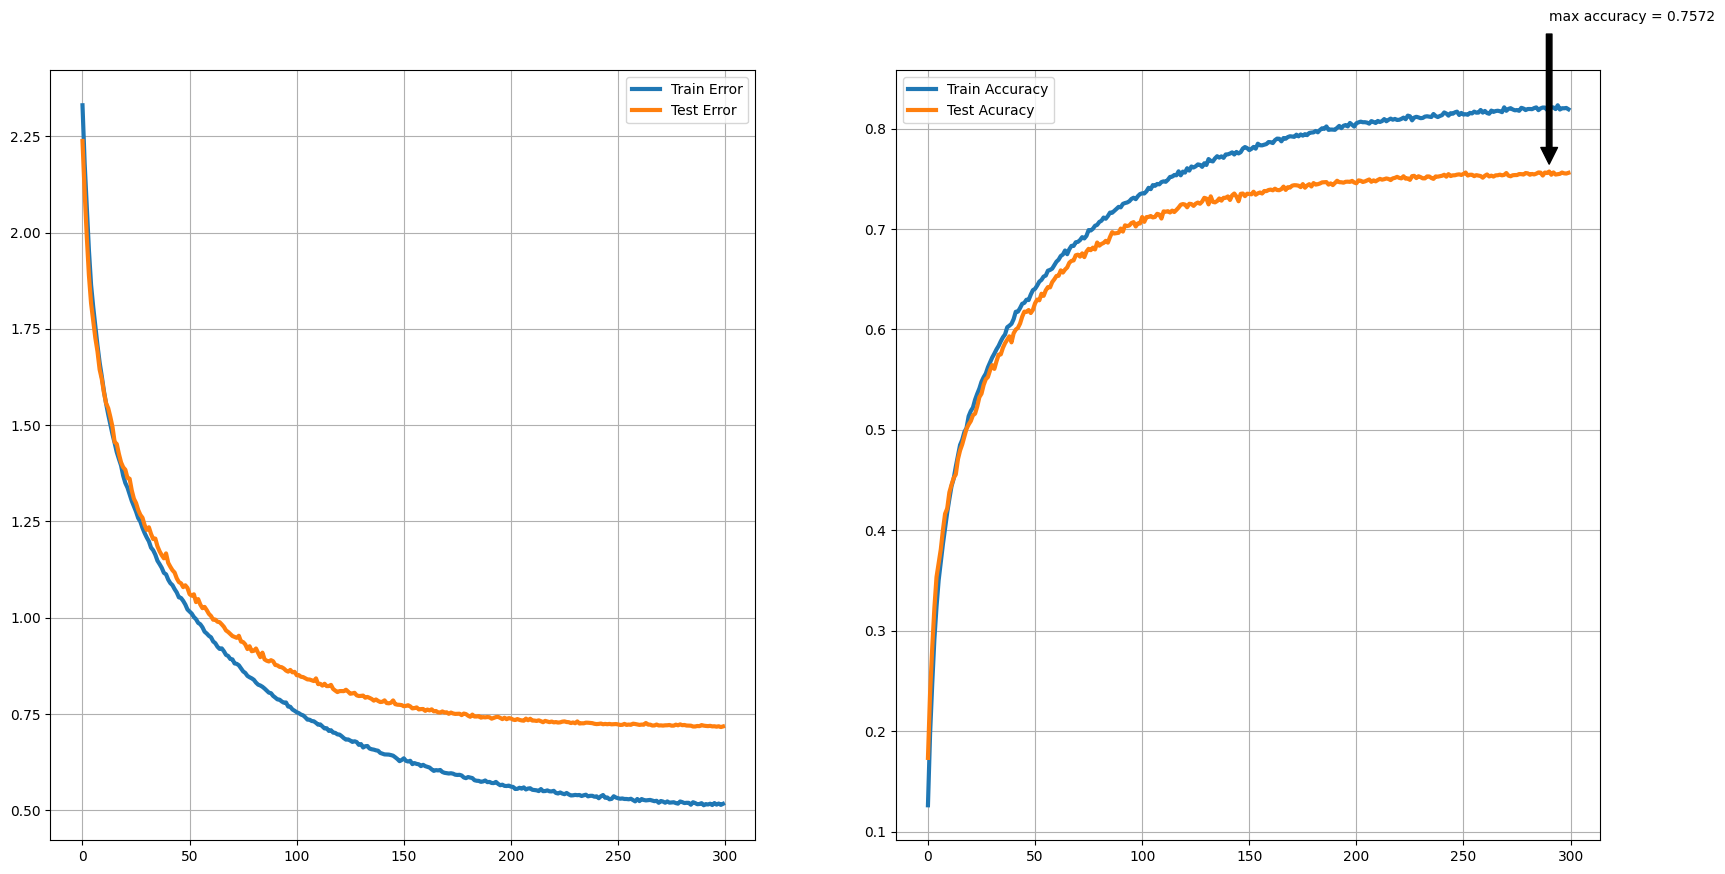

In [ ]:
# Create a figure object with two subplots, with a size of 20 by 10.
f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))

# Set the number of data points in the training data to n.
n = len(train_loss)

# Plot the training loss and testing loss against the number of epochs on the first subplot.
fig1.plot(range(n), train_loss, '-', linewidth='3', label='Train Error')
fig1.plot(range(n), test_loss, '-', linewidth='3', label='Test Error')

# Plot the training accuracy and testing accuracy against the number of epochs on the second subplot.
fig2.plot(range(n), train_accuracy, '-', linewidth='3', label='Train Accuracy')
fig2.plot(range(n), test_accuracy, '-', linewidth='3', label='Test Acuracy')

# Annotate the maximum accuracy achieved with an arrow on the second subplot.
fig2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))

# Turn on the grid lines for both subplots.
fig1.grid(True)
fig2.grid(True)

# Add legends to both subplots.
fig1.legend()
fig2.legend()

# Save the figure to a file named "trainTestCurve.png".
f.savefig("./trainTestCurve.png")


In [ ]:
torch.save(model.state_dict(), '/content/model1.pt')

We tried our model with 3 different optimizer, Adam, AdaGrad and AdaDelta, and below is the bar plot with their accuracy.

Below we are just converting our pt model into onnx format to build the Resnet Architecture diagram

In [ ]:
pip install onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 93.1 MB/s eta 0:00:00


In [ ]:
model = resnet_model()
model.load_state_dict(torch.load('/content/model1.pt'))
# set the model to inference mode
model.eval()

# Let's create a dummy input tensor  
dummy_input = torch.randn(4, 3, 32, 32)
# torch.onnx.export(model, dummy_input, "final_model.onnx")

# Export the model  
torch.onnx.export(model,         # model being run
      dummy_input,       # model input (or a tuple for multiple inputs)
      "final_model1_0pt1.onnx",       # where to save the model  
      export_params=True,  # store the trained parameter weights inside the model file
      opset_version=13,    # the ONNX version to export the model to
      do_constant_folding=True,  # whether to execute constant folding for optimization
      input_names = ['modelInput'],   # the model's input names
      output_names = ['modelOutput'],# the model's output names
)

torch.save(model.state_dict(), 'final_model1_0pt1.pt')




Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
from google.colab import files
files.download('final_model1_0pt001.onnx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import urllib.request
from IPython.display import SVG, display

# URL of the SVG image we are downloading
url = "https://svgshare.com/i/s0w.svg"

# Download the SVG image
svg_data = urllib.request.urlopen(url).read()

# Display the SVG image in Colab
display(SVG(svg_data))


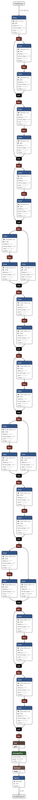

In [ ]:
import urllib.request
from IPython.display import Image, display

# URL of the PNG image
url = "https://i.postimg.cc/hP7v0zPk/final-model1-1-onnx.png"

# Download the PNG image
png_data = urllib.request.urlopen(url).read()

# Display the PNG image in Colab
display(Image(png_data))
